# Разработка прогнозных моделей удовлетворенности сотрудников и оттока персонала для HR-отдела

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Описание задачи

**Краткое описание**

Удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Необходимо построить две прогнозные модели. Первая - предсказывает уровень удовлетворённости сотрудника, вторая - предсказывает
уволится ли сотрудник.

**Описание данных**

Для этой задачи заказчик предоставил данные с признаками:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.
- quit - предсказывает уволился ли сотрудник


**План работы**

1. Подготовка данных:
   - Получение данных от заказчика.
   - Анализ данных: определение типов данных, выявление пропусков, обработка дубликатов.
   - Преобразование данных: перевод категориальных признаков в числовые, нормализация/стандартизация числовых признаков.
   - Разделение данных на тренировочный, тестовый наборы.
2. Модель предсказания удовлетворенности:
   - Обучение модели на тренировочных данных.
   - Оценка модели на тестовых данных по метрике SMAPE.
3. Модель предсказания оттока сотрудников:
   - Обучение модели на тренировочных данных.
   - Оценка модели на тестовых данных на метрику ROC-AUC.

### Загрузка используемых в проекте библиотек

In [1]:
# Необходимый набор библиотек
!pip install matplotlib==3.7.3 numpy==1.22 seaborn==0.11.1 -q
!pip install --upgrade scikit-learn -q
!pip install shap -q
!pip install phik -q
!pip install python-levenshtein -q

# Работа с данными
import pandas as pd
import numpy as np

# Визуализация, построение графиков
from matplotlib import pyplot as plt
import seaborn as sns

# Применение регулярных выражений
import re

# Вывод корреляционной матрицы
import phik

# Разбиение данных на тренировочную выборку и тестовую
from sklearn.model_selection import train_test_split

# Создание pipeline
from sklearn.pipeline import Pipeline

# Классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# Класс для работы с пропусками
from sklearn.impute import SimpleImputer

# Функция для работы с метриками
from sklearn.metrics import roc_auc_score, make_scorer

# RandomizedSearchCV - библиотека, которая используется для рандомизированного поиска гиперпараметров в машинном обучении
# GridSearchCV - библиотека, которая помогает автоматизировать настройку гиперпараметров в машинном обучении
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Модели машинного обучения
# Логистическая регрессия
from sklearn.linear_model import LogisticRegression
# Линейная регрессия
from sklearn.linear_model import LinearRegression
# k-ближайших соседей
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# Дерево решений
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
# Метод опорных векторов
from sklearn.svm import SVC, SVR

# Кодировка целевого признака
from sklearn.preprocessing import LabelEncoder
import shap

# Проверка уникальности значений в object
from fuzzywuzzy import fuzz

# Настройка вывода всех столбцов для метода display
pd.set_option('display.max_columns', None)

### Загрузка данных

Загрузим данные предоставленные заказчиком и отобразим первичную информацию по каждому датасету

In [2]:
# Тренировочная выборка
train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
# Входные признаки тестовой выборки
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
# Целевой признак тестовой выборки
test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [3]:
# Создадим функцию отоброжения первичной информации о датасете (выборке)
def data_head_desc_info(data):
    try:
        # сразу преобразуем наименование столбцов в нижний регистр и стиль snake_case
        data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() for i in data.columns]
        print('---------------------------------------------------------------------------------------------------------------')
        print('Первые 3 строки:')
        print('---------------------------------------------------------------------------------------------------------------')
        display(data.head(3))
        print('---------------------------------------------------------------------------------------------------------------')
        print('Описание данных:')
        print('---------------------------------------------------------------------------------------------------------------')
        display(data.describe(include = "all"))
        print('---------------------------------------------------------------------------------------------------------------')
        print('Общая информация о датафрейме')
        print('---------------------------------------------------------------------------------------------------------------')
        display(data.info())
        print('---------------------------------------------------------------------------------------------------------------')
        print('Исследование пропусков')
        print('---------------------------------------------------------------------------------------------------------------')
        frame = {
                'nan_кол-во': data.isna().sum().sort_values(ascending=False),
                'nan_%': round((data.isna().mean() * 100), 1).sort_values(ascending=False),
            }
        nan_data = pd.DataFrame(frame)
        nan_data = nan_data.style.format({'nan_%': '{:.1f}%'})
        nan_data = nan_data.background_gradient(axis=0, cmap='YlOrRd')
        display(nan_data)
        print('---------------------------------------------------------------------------------------------------------------')
        print('Доля явных дубликатов')
        print('---------------------------------------------------------------------------------------------------------------')
        print(f"{data.duplicated().sum() / data.shape[0] * 100:.2f}%")
    except:
        return 'Проверьте параметры'

In [4]:
# Функция проверки неявных дубликатов в столбцах типа object
def check_unique_object_columns(df):
    print('------------------------------------------------------------------------------------------------------------------')
    print('Проверка неявных дубликатов в столбцах типа object:')
    print('------------------------------------------------------------------------------------------------------------------')
    if not isinstance(df, pd.DataFrame):
        print("Вход должен быть DataFrame pandas.")
        return None

    object_cols = df.select_dtypes(include=['object']).columns
    if object_cols.empty:
        print("В DataFrame нет столбцов типа object.")
        return None

    results = {}
    for col in object_cols:
        unique_vals = df[col].unique()
        results[col] = {
            'число_уникальных_значений': len(unique_vals),
            # Преобразование в список для лучшего отображения
            'уникальных_значения': unique_vals.tolist(),
            'потенциальные_дубликаты': []
        }

        # Базовая проверка потенциальных дубликатов:
        # Проверяет значения с разными регистрами или незначительными вариациями.
        for i, val in enumerate(unique_vals):
            if unique_vals.tolist().count(val) > 1 and val != '':  # важная проверка на пустую строку!
                for j, other_val in enumerate(unique_vals):
                    if i != j and fuzz.ratio(val.lower(), other_val.lower()) >= 90:
                        #  Уникальная строка не должна быть в списке дубликатов
                        if other_val not in results[col]['потенциальные_дубликаты']: 
                            results[col]['потенциальные_дубликаты'].append(other_val)

    result_df = pd.DataFrame.from_dict(results, orient='index')
    display(result_df)
    
    print('------------------------------------------------------------------------------------------------------------------')
    print('Вывод всех уникальных значений:')
    print('------------------------------------------------------------------------------------------------------------------')
    
    # Вывод всех уникальных значений
    for col in object_cols:
        print(f"\nСтолбец {col}:")
        print(f"Уникальные значения: {result_df.loc[col, 'уникальных_значения']}")

### Обзор данных

#### Обзор train_job_satisfaction_rate

In [5]:
data_head_desc_info(train_job_satisfaction_rate)

---------------------------------------------------------------------------------------------------------------
Первые 3 строки:
---------------------------------------------------------------------------------------------------------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11


---------------------------------------------------------------------------------------------------------------
Описание данных:
---------------------------------------------------------------------------------------------------------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,3994,3996,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000.000000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,NaN,1512,1894,2066,NaN,3880,3441,NaN,NaN,NaN
mean,544957.621000,NaN,NaN,NaN,3.718500,NaN,NaN,3.476500,33926.700000,0.533995
std,257883.104622,NaN,NaN,NaN,2.542513,NaN,NaN,1.008812,14900.703838,0.225327
min,100954.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,0.030000
25%,322836.750000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,0.360000
50%,534082.500000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,0.560000
75%,771446.000000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,0.710000


---------------------------------------------------------------------------------------------------------------
Общая информация о датафрейме
---------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64

None

---------------------------------------------------------------------------------------------------------------
Исследование пропусков
---------------------------------------------------------------------------------------------------------------


,nan_кол-во,nan_%
dept,6,0.2%
level,4,0.1%
id,0,0.0%
workload,0,0.0%
employment_years,0,0.0%
last_year_promo,0,0.0%
last_year_violations,0,0.0%
supervisor_evaluation,0,0.0%
salary,0,0.0%
job_satisfaction_rate,0,0.0%


---------------------------------------------------------------------------------------------------------------
Доля явных дубликатов
---------------------------------------------------------------------------------------------------------------
0.00%


In [6]:
check_unique_object_columns(train_job_satisfaction_rate)

------------------------------------------------------------------------------------------------------------------
Проверка неявных дубликатов в столбцах типа object:
------------------------------------------------------------------------------------------------------------------


,число_уникальных_значений,уникальных_значения,потенциальные_дубликаты
dept,6,"[sales, hr, technology, purchasing, marketing,...",[]
level,4,"[junior, middle, sinior, nan]",[]
workload,3,"[medium, high, low]",[]
last_year_promo,2,"[no, yes]",[]
last_year_violations,2,"[no, yes]",[]


------------------------------------------------------------------------------------------------------------------
Вывод всех уникальных значений:
------------------------------------------------------------------------------------------------------------------

Столбец dept:
Уникальные значения: ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]

Столбец level:
Уникальные значения: ['junior', 'middle', 'sinior', nan]

Столбец workload:
Уникальные значения: ['medium', 'high', 'low']

Столбец last_year_promo:
Уникальные значения: ['no', 'yes']

Столбец last_year_violations:
Уникальные значения: ['no', 'yes']


**Промежуточный вывод по выборке train_job_satisfaction_rate**

- В данных train_job_satisfaction_rate имеются пропуски в столбцах dept (2 пропуска) и level (1 пропуск). Сделаем это в пайплайне
- Тип данных в столбцах level, workload следует сделать категориальным порядковым. Сделаем это в пайплайне
- Столбец id сделаем индексом, чтобы мы могли соотносить значения во всех выборках. Сделаем это в предобработке данных

#### Обзор test_features

In [7]:
data_head_desc_info(test_features)

---------------------------------------------------------------------------------------------------------------
Первые 3 строки:
---------------------------------------------------------------------------------------------------------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200


---------------------------------------------------------------------------------------------------------------
Описание данных:
---------------------------------------------------------------------------------------------------------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,2000.000000,1998,1999,2000,2000.000000,2000,2000,2000.000000,2000.000000
unique,NaN,6,3,4,NaN,2,2,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN
freq,NaN,763,974,1043,NaN,1937,1738,NaN,NaN
mean,552765.213500,NaN,NaN,NaN,3.666500,NaN,NaN,3.526500,34066.800000
std,253851.326129,NaN,NaN,NaN,2.537222,NaN,NaN,0.996892,15398.436729
min,100298.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000
25%,339052.000000,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,22800.000000
50%,550793.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000
75%,765763.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000


---------------------------------------------------------------------------------------------------------------
Общая информация о датафрейме
---------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

---------------------------------------------------------------------------------------------------------------
Исследование пропусков
---------------------------------------------------------------------------------------------------------------


,nan_кол-во,nan_%
dept,2,0.1%
employment_years,0,0.0%
id,0,0.0%
last_year_promo,0,0.0%
last_year_violations,0,0.0%
level,1,0.0%
salary,0,0.0%
supervisor_evaluation,0,0.0%
workload,0,0.0%


---------------------------------------------------------------------------------------------------------------
Доля явных дубликатов
---------------------------------------------------------------------------------------------------------------
0.00%


In [8]:
check_unique_object_columns(test_features)

------------------------------------------------------------------------------------------------------------------
Проверка неявных дубликатов в столбцах типа object:
------------------------------------------------------------------------------------------------------------------


,число_уникальных_значений,уникальных_значения,потенциальные_дубликаты
dept,7,"[marketing, hr, sales, purchasing, technology,...",[]
level,4,"[junior, middle, sinior, nan]",[]
workload,4,"[medium, low, high, ]",[]
last_year_promo,2,"[no, yes]",[]
last_year_violations,2,"[no, yes]",[]


------------------------------------------------------------------------------------------------------------------
Вывод всех уникальных значений:
------------------------------------------------------------------------------------------------------------------

Столбец dept:
Уникальные значения: ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' ']

Столбец level:
Уникальные значения: ['junior', 'middle', 'sinior', nan]

Столбец workload:
Уникальные значения: ['medium', 'low', 'high', ' ']

Столбец last_year_promo:
Уникальные значения: ['no', 'yes']

Столбец last_year_violations:
Уникальные значения: ['no', 'yes']


**Промежуточный вывод по выборке test_features**

- В данных test_features имеются пропуски в столбцах dept (2 пропуска) и level (1 пропуск). Применим процесс предподготоки из пайплайна
- В столбцах dept и workload есть пустые значения заполненные пробелом, которые нужно заменить на nan. Сделаем это в предобработке данных
- Тип данных в столбцах level, workload следует сделать категориальным порядковым. Применим процесс предподготоки из пайплайна
- Столбец id сделаем индексом, чтобы мы могли соотносить значения во всех выборках. Сделаем это в предобработке данных

#### Обзор test_target_job_satisfaction_rate

In [9]:
data_head_desc_info(test_target_job_satisfaction_rate)

---------------------------------------------------------------------------------------------------------------
Первые 3 строки:
---------------------------------------------------------------------------------------------------------------


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60


---------------------------------------------------------------------------------------------------------------
Описание данных:
---------------------------------------------------------------------------------------------------------------


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


---------------------------------------------------------------------------------------------------------------
Общая информация о датафрейме
---------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

---------------------------------------------------------------------------------------------------------------
Исследование пропусков
---------------------------------------------------------------------------------------------------------------


,nan_кол-во,nan_%
id,0,0.0%
job_satisfaction_rate,0,0.0%


---------------------------------------------------------------------------------------------------------------
Доля явных дубликатов
---------------------------------------------------------------------------------------------------------------
0.00%


In [10]:
check_unique_object_columns(test_target_job_satisfaction_rate)

------------------------------------------------------------------------------------------------------------------
Проверка неявных дубликатов в столбцах типа object:
------------------------------------------------------------------------------------------------------------------
В DataFrame нет столбцов типа object.


**Промежуточный вывод по выборке check_unique_object_columns**

- Столбец id сделаем индексом, чтобы мы могли соотносить значения во всех выборках. Сделаем это в предобработке данных

### Предобработка данных

Замена ячеек заполненных ' ' на nan в столбцах dept и workload в выборке test_features

In [11]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

frame = {'nan_кол-во': test_features.isna().sum().sort_values(ascending=False),
         'nan_%': round((test_features.isna().mean() * 100), 1).sort_values(ascending=False),}
nan_data = pd.DataFrame(frame)
nan_data = nan_data.style.format({'nan_%': '{:.1f}%'})
nan_data = nan_data.background_gradient(axis=0, cmap='YlOrRd')
display(nan_data)

,nan_кол-во,nan_%
dept,3,0.2%
employment_years,0,0.0%
id,0,0.0%
last_year_promo,0,0.0%
last_year_violations,0,0.0%
level,1,0.0%
salary,0,0.0%
supervisor_evaluation,0,0.0%
workload,1,0.0%


In [12]:
print(test_features['dept'].unique())
print(test_features['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['medium' 'low' 'high' nan]


Преобразование id в индекс во всех выборках

In [13]:
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')
test_features = test_features.set_index('id')
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.set_index('id')

### Исследовательский анализ

Цель исследовательского анализа - оценка качества данных. Нам интересно в первую очередь понять как распределены данные, есть ли в них аномалии и выбросы.

#### Исследование train_job_satisfaction_rate

Выведем гистограммы и блоксплоты для числовых значений выборки. Посмотрим краткое статистическое описание и сделаем выводы.

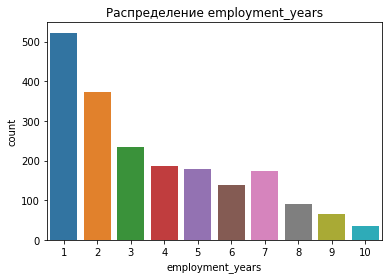

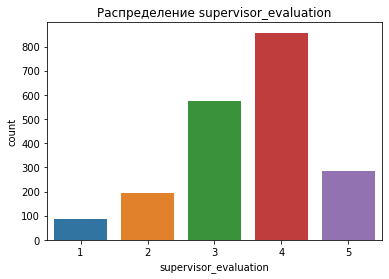

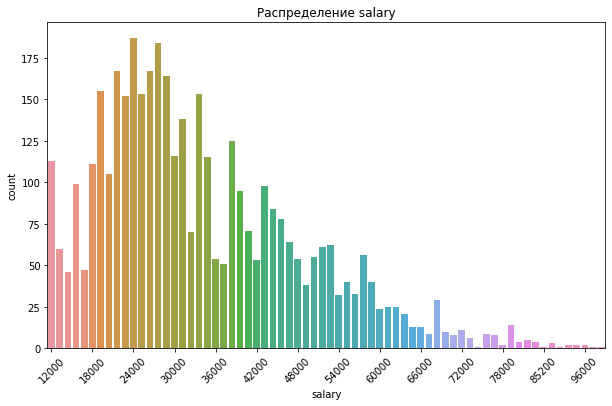

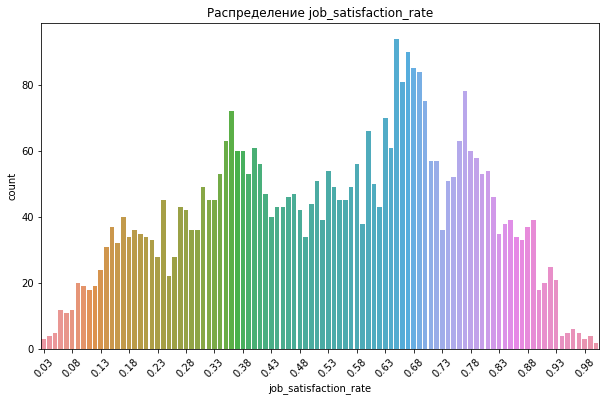

In [14]:
eda_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
    
for col in eda_cols:
    if col == 'salary' or col == 'job_satisfaction_rate':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, data=train_job_satisfaction_rate)
        plt.xticks(rotation=45)
        xticks = plt.xticks()[0]
        selected_xticks = xticks[::5]
        plt.xticks(selected_xticks)
        plt.title(f'Распределение {col}')
        plt.show()
    else:
        sns.countplot(x=col, data=test_features)
        plt.title(f'Распределение {col}')
        plt.show()

Аномальные значения не наблюдаются. Ближе всего к нормальному распределение job_satisfaction_rate, которое не должно существенно влиять на работу моделей. У остальных признаков распределение ассимитричное, что часто встречается в жизни и что может повлиять на работу линейных моделей и привести к неточным прогнозам. Сгладить ассиметрию нам помогут StandardScaler и MinMaxScaler, которые мы используем в пайплайне.

employment_years и supervisor_evaluation - дискретные признаки, хоть и представлены в численном виде. Для этих признаков не нужно строить ящики с усами, так как признак имеет, скорее, распределение категориального признака, пусть и представленного уже в численном виде.

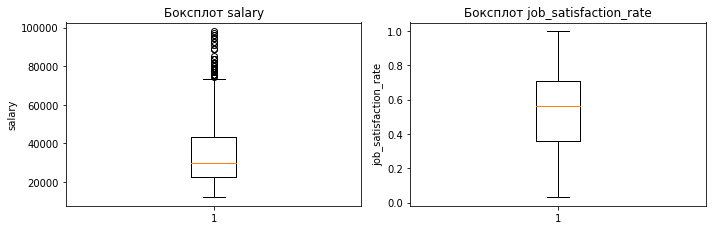

In [15]:
# Отфильтруем только числовые столбцы
numeric_columns = train_job_satisfaction_rate.select_dtypes(include=['number']).columns

plt.figure(figsize=(10, 6))
for i, column in enumerate(numeric_columns):
    if column != 'employment_years' and column != 'supervisor_evaluation':
        plt.subplot(2, 2, i + 1)
        plt.boxplot(train_job_satisfaction_rate[column])
        plt.title(f'Боксплот {column}')
        plt.ylabel(column)
plt.tight_layout()
plt.show()

**salary**: есть выбросы, но они объясняются высокими зарплатами ценных специалистов и руководителей.

Взглянем на выбросы в столбце salary отноительно целевого признака job_satisfaction_rate и сделаем вывод нужно ли эти выбросы исключить из выборки.

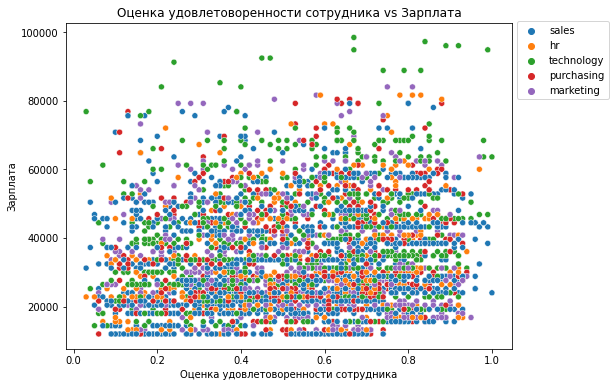

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_job_satisfaction_rate['job_satisfaction_rate'], y=train_job_satisfaction_rate['salary'],
                hue=train_job_satisfaction_rate['dept'])
plt.xlabel('Оценка удовлетоворенности сотрудника')
plt.ylabel('Зарплата')
plt.title(f'Оценка удовлетоворенности сотрудника vs Зарплата')
plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.75), ncol=1)
plt.show()

Самые высокие зарплаты у технических специалистов и выбросы в данном случае отображают положение данной подгруппы (тех. специалисты) по показателяю. А значит они нужны нам для построения и прогносзирования модели по данной подгруппе.

Изучим категориальные покзатели.

Посмотримна респределение категориальных показаьелей, построим их гистограммы

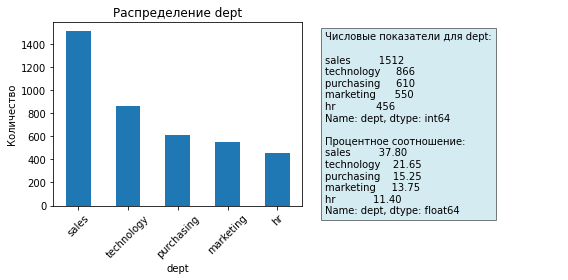

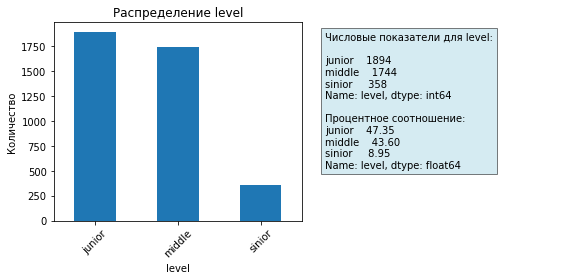

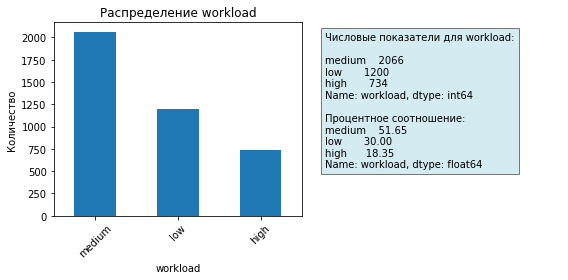

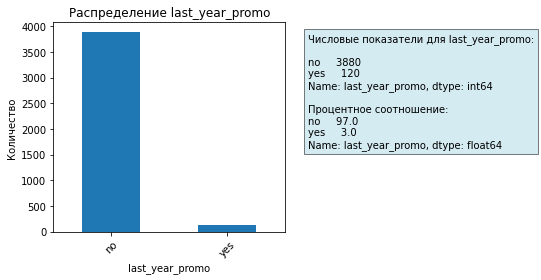

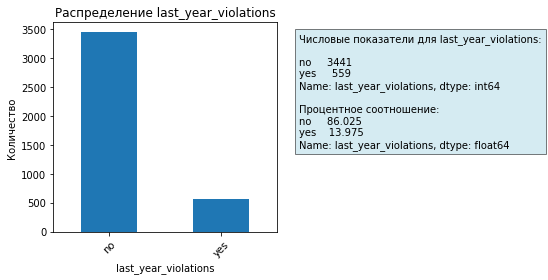

In [17]:
# Гистограммы распределения категориальных переменных
cols_to_plot = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for i, col in enumerate(cols_to_plot):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))  # Создаем фигуру с двумя подграфиками

    # Подграфик 1: Гистограмма
    value_counts = train_job_satisfaction_rate[col].value_counts()
    value_counts.plot(kind='bar', ax=ax1)  
    ax1.set_title(f'Распределение {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Количество')
    ax1.tick_params(axis='x', rotation=45) 

    # Подграфик 2: Вывод числовых значений
    ax2.axis('off')  
    ax2.text(0.05, 0.95,
             f"Числовые показатели для {col}:\n\n{value_counts}\n\nПроцентное соотношение:\n{value_counts / len(train_job_satisfaction_rate) * 100}", 
             fontsize=10,
             ha="left",
             va="top",
             bbox={'facecolor': 'lightblue', 'alpha': 0.5}) 

    plt.tight_layout()
    plt.show()

- dept: отдел продаж — самый большой. Далле интересно будет изучить влияет ли отдел на оценку удовлетворенности сотрудников. В одном отделе сотрудники чквствуют себя лучше в другом хуже.
- last_year_promo: низкий процент повышения (3%), это может говорить опроблемах х с системой карьерного роста.
- last_year_violations: 14%, нарушения могут влияють на уровень удовлетворенности сотрудников

Посмотрим распределение job_satisfaction_rate по категориальным признакам

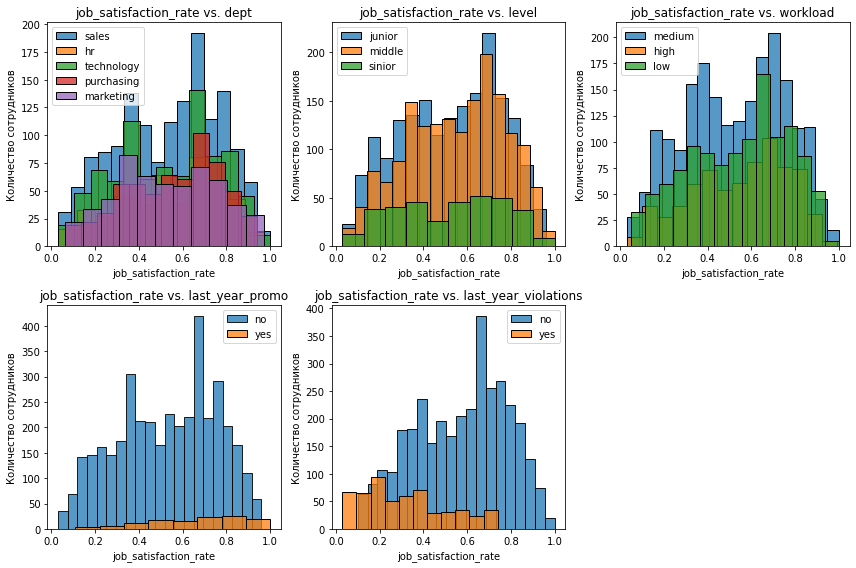

In [18]:
cols_to_plot = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

plt.figure(figsize=(12, 8))

for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 3, i + 1)
    
    # Сопоставляем цвета категориям (опционально)
    color_map = plt.cm.tab10(range(len(train_job_satisfaction_rate[col].unique())))

    for j, category in enumerate(train_job_satisfaction_rate[col].unique()):
        subset = train_job_satisfaction_rate[train_job_satisfaction_rate[col] == category]
        # Строим гистограмму для каждой категории
        sns.histplot(x=subset['job_satisfaction_rate'], stat="count", label=category, color=color_map[j]) 

    plt.title(f'job_satisfaction_rate vs. {col}')
    plt.xlabel('job_satisfaction_rate')
    plt.ylabel('Количество сотрудников')
    plt.legend()

plt.tight_layout()
plt.show()

На получившихся гистограммах видим:
- смещение вправо распределения по сотрудникам получившим повышение, это указывает на положительное влияние показателя yes last_year_promo на job_satisfaction_rate. 
- смещение влево распределения по сотрудникам имевших нарушение, это указывает на отрицательное влияние показателя yes last_year_violations на job_satisfaction_rate.
- по остальным гистограммам заметного смещения не наблюдается. Распределения job_satisfaction_rate выглядят относительно симметричными и близкими к нормальному распределению, что может указывать на то, что данные категориальные переменные (dept, level, workload) не оказывают значительного влияния на уровень удовлетворенности работников, либо имеют слабое влияние.

#### Исследование test_features и test_target_job_satisfaction_rate

Взглянем качество тестовых данных, сравним с тренировочными данными.

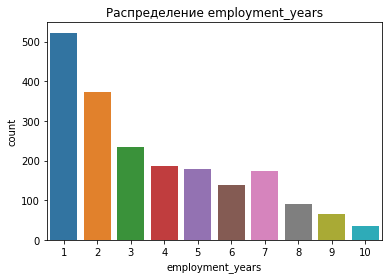

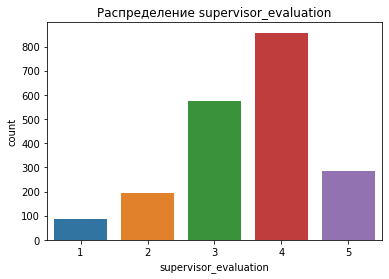

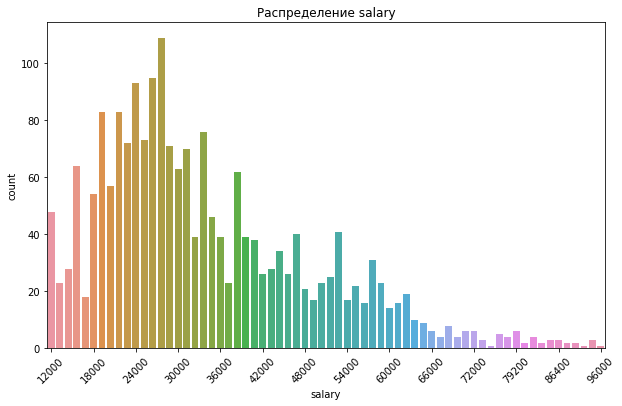

In [19]:
eda_cols = ['employment_years', 'supervisor_evaluation', 'salary']

for col in eda_cols:
    if col == 'salary':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, data=test_features)
        plt.xticks(rotation=45)
        xticks = plt.xticks()[0]
        selected_xticks = xticks[::5]
        plt.xticks(selected_xticks)
        plt.title(f'Распределение {col}')
        plt.show()
    else:
        sns.countplot(x=col, data=test_features)
        plt.title(f'Распределение {col}')
        plt.show()

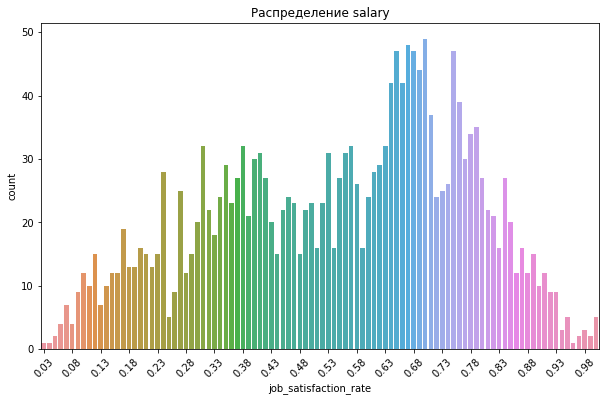

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='job_satisfaction_rate', data=test_target_job_satisfaction_rate)
plt.xticks(rotation=45)
xticks = plt.xticks()[0]
selected_xticks = xticks[::5]
plt.xticks(selected_xticks)
plt.title(f'Распределение {col}')
plt.show()

Очень похожее распределение. Можно сделать вывод, что модель обученая на тренировочной выборке будет хорошо предсказывать результат на тестовой выборке

### Корреляционный анализ

Проведем корреляционный анализ. Найдем признаки, с которыми коррелирует целевой признак.

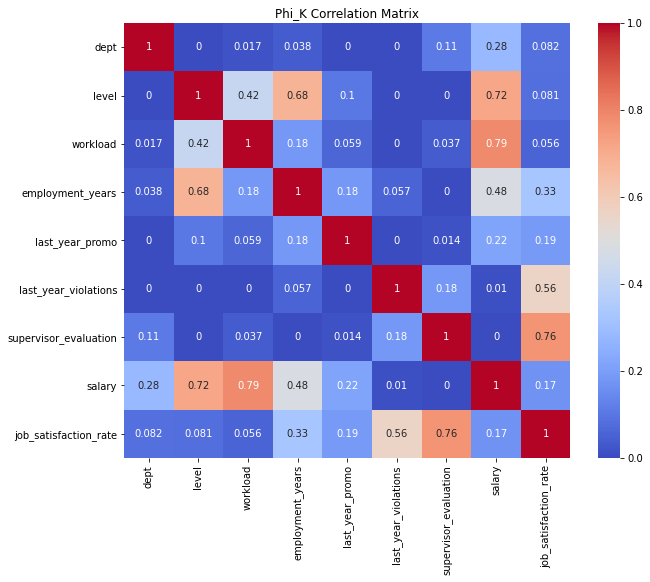

In [21]:
# Список  количественных  столбцов
interval_cols = ['salary', 'job_satisfaction_rate']

# Вычисляем  матрицы  корреляции. Передаем только список с количественными признаки. 
# Дадьше phik определит остальные признаки как категориальные
corr_matrix = train_job_satisfaction_rate.phik_matrix(interval_cols=interval_cols)

# Визуализация  матрицы  корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

In [22]:
# Выведем корреляцию целевого признака job_satisfaction_rate с остальными входными признаками
print(corr_matrix['job_satisfaction_rate'].sort_values(ascending=False))

job_satisfaction_rate    1.000000
supervisor_evaluation    0.764364
last_year_violations     0.560348
employment_years         0.325603
last_year_promo          0.190803
salary                   0.165830
dept                     0.082086
level                    0.080620
workload                 0.056128
Name: job_satisfaction_rate, dtype: float64


**Вывод**
- supervisor_evaluation (0.76): сильная положительная корреляция, оценка руководителя оказывает значительное влияние на уровень удовлетворённости сотрудников
- supervisor_evaluation (0.56): сильная корреляция, тут скорее обратная логика, чем менее удовлетворен сотрудник тем больше он нарушает, но тем не менее является показателем, того что сотрудник неудовлетворен чем то.
- last_year_violations (0.32): умеренная корреляция, может указывать на то, что более опытные сотрудники, как правило, более удовлетворены своей работой
- last_year_0.17): слабая положительная корреляция, может указывать на то, что зарплата оказывает очень слабое влияния на удовлетворённость
- level, dept, workload практически не коррелируют

Мультиколинеарность отсутствует.

   Оптимальным для обучения модели считается 7-10 входных признаков. У нас всего их 8, 3 из них (level, dept, workload) практически не коррелируют  целевым признаком. Признаки с level, dept, workload в принципе можно удалить, но можно и оставить. В нашем пайплайне будет применена регуляризация, которая уменьшит влияние сильно коррелирующих признаков и повысит или же обнулит влияние признаков с меньшей корреляцией и тем самым повысит точность нашей модели.

### Обучение модели

#### Создание пайплайна

Разделим данные на нужные для обучения моделей выборки X_train, X_test, y_train, y_test.
<br>X_test и y_test у нас уже есть это test_features и test_target_job_satisfaction_rate соответственно
<br> Осталось разделить train_job_satisfaction_rate на X_train и y_train

In [23]:
X_test = test_features
y_test = test_target_job_satisfaction_rate

X_train = train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
y_test = test_target_job_satisfaction_rate['job_satisfaction_rate']

In [24]:
print(type(X_test))
print(type(y_test))
print(type(X_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [25]:
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

In [26]:
# y_train = pd.DataFrame(y_train, columns=['job_satisfaction_rate'])

In [27]:
y_train.index

Int64Index([100954, 101057, 101074, 101081, 101129, 101159, 101249, 101334,
            101661, 101890,
            ...
            996405, 996910, 997136, 997545, 997711, 998223, 998838, 999264,
            999348, 999521],
           dtype='int64', name='id', length=4000)

In [28]:
print(X_train['level'].unique())
print(X_train['workload'].unique())

['junior' 'middle' 'sinior' nan]
['low' 'medium' 'high']


Создадим списки с названиями признаков, чтобы на основании этих списков прокодировать признаки в пайплайне

In [29]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [30]:
RANDOM_STATE = 42

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore')) 
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns) # StandardScaler() больше подходит для линейныхх моделей, чем MinMaxScaler()
    ], 
    remainder='passthrough'
)

In [31]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

In [32]:
%%time
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 7), # Чем больше значение max_depth, тем сложнее дерево и тем больше в нём может быть узлов.
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(40, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
    # Метод опорных векторов для задач регрессии. Регрессия опорных векторов (SVR)
    {
        'models': [SVR()],
        'models__kernel': ['linear', 'rbf'],  # Ядра для SVR
        'models__C': [0.1, 1, 10, 100], # Параметр регуляризации
        'models__gamma': ['scale'],                  # Параметр ядра (для 'rbf', 'poly', 'sigmoid')
        'models__degree': [2, 3],                         # Степень полинома (для 'poly')
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],  # Предобработка числовых признаков
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=make_scorer(smape, greater_is_better=False),
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика SMAPE лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_pred = randomized_search.predict(X_test)
smape_score = smape(y_test, y_test_pred)
print(f'Метрика SMAPE на тестовой выборке: {smape_score}')


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [33]:
# Извлекаем результаты из cv_results_
results = randomized_search.cv_results_

# Создаём DataFrame из отфильтрованных результатов
results_df = pd.DataFrame(results)

# Выводим результаты по моделям
print(results_df)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.055471      0.058167         0.041107        0.000749   
1       0.023657      0.000415         0.009868        0.000090   
2       0.024565      0.000594         0.010087        0.000426   
3       0.024027      0.000866         0.009910        0.000146   
4       0.401421      0.018108         0.031859        0.003052   
5       0.023699      0.000371         0.017276        0.000360   
6       0.027728      0.002434         0.039090        0.000467   
7       5.769454      0.151056         0.033736        0.000904   
8       0.324179      0.012633         0.033148        0.000443   
9       0.020905      0.000472         0.008402        0.000112   

  param_preprocessor__num  param_models__n_neighbors  \
0          MinMaxScaler()                       41.0   
1          MinMaxScaler()                        NaN   
2          MinMaxScaler()                        NaN   
3          MinMaxScaler()             

#### Вывод

1. Лучшая модель:

SVR(C=10) с StandardScaler как предобработкой показала самый низкий SMAPE (-14.48) на тренировочной выборке.
SMAPE на тестовой выборке немного выше (13.51), что указывает на возможное переобучение модели.

2. Другие модели:

DecisionTreeRegressor с StandardScaler и гиперпараметрами max_depth=3, max_features=4 (строка 4) также показывает хорошие результаты (-14.48 на тренировочной выборке).
KNeighborsRegressor и SVR с другими гиперпараметрами демонстрируют более низкое качество по сравнению с лучшими моделями SVR и DecisionTreeRegressor.
3. Предобработка:

StandardScaler показывает лучшие результаты по сравнению с MinMaxScaler и passthrough.

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

Загрузим данные предоставленные заказчиком и отобразим первичную информацию по каждому датасету

In [34]:
# Тренировочная выборка
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
# Входные признаки тестовой выборки те же, что и в прошлой задаче
# test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
# Целевой признак тестовой выборки
test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

#### Обзор train_quit

In [35]:
data_head_desc_info(train_quit)

---------------------------------------------------------------------------------------------------------------
Первые 3 строки:
---------------------------------------------------------------------------------------------------------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no


---------------------------------------------------------------------------------------------------------------
Описание данных:
---------------------------------------------------------------------------------------------------------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
count,4000.000000,4000,4000,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,2
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,no
freq,NaN,1438,1949,2118,NaN,3887,3455,NaN,NaN,2872
mean,552099.283750,NaN,NaN,NaN,3.701500,NaN,NaN,3.474750,33805.800000,NaN
std,260158.031387,NaN,NaN,NaN,2.541852,NaN,NaN,1.004049,15152.415163,NaN
min,100222.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,NaN
25%,327785.750000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,NaN
50%,546673.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,NaN
75%,781497.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,NaN


---------------------------------------------------------------------------------------------------------------
Общая информация о датафрейме
---------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)

None

---------------------------------------------------------------------------------------------------------------
Исследование пропусков
---------------------------------------------------------------------------------------------------------------


,nan_кол-во,nan_%
id,0,0.0%
dept,0,0.0%
level,0,0.0%
workload,0,0.0%
employment_years,0,0.0%
last_year_promo,0,0.0%
last_year_violations,0,0.0%
supervisor_evaluation,0,0.0%
salary,0,0.0%
quit,0,0.0%


---------------------------------------------------------------------------------------------------------------
Доля явных дубликатов
---------------------------------------------------------------------------------------------------------------
0.00%


In [36]:
check_unique_object_columns(train_quit)

------------------------------------------------------------------------------------------------------------------
Проверка неявных дубликатов в столбцах типа object:
------------------------------------------------------------------------------------------------------------------


,число_уникальных_значений,уникальных_значения,потенциальные_дубликаты
dept,5,"[sales, purchasing, marketing, technology, hr]",[]
level,3,"[middle, junior, sinior]",[]
workload,3,"[high, medium, low]",[]
last_year_promo,2,"[no, yes]",[]
last_year_violations,2,"[no, yes]",[]
quit,2,"[no, yes]",[]


------------------------------------------------------------------------------------------------------------------
Вывод всех уникальных значений:
------------------------------------------------------------------------------------------------------------------

Столбец dept:
Уникальные значения: ['sales', 'purchasing', 'marketing', 'technology', 'hr']

Столбец level:
Уникальные значения: ['middle', 'junior', 'sinior']

Столбец workload:
Уникальные значения: ['high', 'medium', 'low']

Столбец last_year_promo:
Уникальные значения: ['no', 'yes']

Столбец last_year_violations:
Уникальные значения: ['no', 'yes']

Столбец quit:
Уникальные значения: ['no', 'yes']


#### Обзор test_target_quit

In [37]:
data_head_desc_info(test_target_quit)

---------------------------------------------------------------------------------------------------------------
Первые 3 строки:
---------------------------------------------------------------------------------------------------------------


,id,quit
0,999029,yes
1,372846,no
2,726767,no


---------------------------------------------------------------------------------------------------------------
Описание данных:
---------------------------------------------------------------------------------------------------------------


,id,quit
count,2000.000000,2000
unique,NaN,2
top,NaN,no
freq,NaN,1436
mean,552765.213500,NaN
std,253851.326129,NaN
min,100298.000000,NaN
25%,339052.000000,NaN
50%,550793.000000,NaN
75%,765763.750000,NaN


---------------------------------------------------------------------------------------------------------------
Общая информация о датафрейме
---------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

---------------------------------------------------------------------------------------------------------------
Исследование пропусков
---------------------------------------------------------------------------------------------------------------


,nan_кол-во,nan_%
id,0,0.0%
quit,0,0.0%


---------------------------------------------------------------------------------------------------------------
Доля явных дубликатов
---------------------------------------------------------------------------------------------------------------
0.00%


In [38]:
check_unique_object_columns(test_target_quit)

------------------------------------------------------------------------------------------------------------------
Проверка неявных дубликатов в столбцах типа object:
------------------------------------------------------------------------------------------------------------------


,число_уникальных_значений,уникальных_значения,потенциальные_дубликаты
quit,2,"[yes, no]",[]


------------------------------------------------------------------------------------------------------------------
Вывод всех уникальных значений:
------------------------------------------------------------------------------------------------------------------

Столбец quit:
Уникальные значения: ['yes', 'no']


#### Вывод
Ошибок в данных не выявленно, предобработка не требуется

### Исследовательский анализ

In [39]:
# Сделаем id индексом, чтобы исключить влияние id на исследование и модель обучения 
train_quit = train_quit.set_index('id')

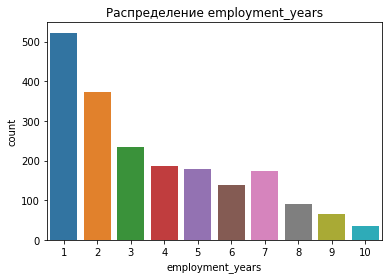

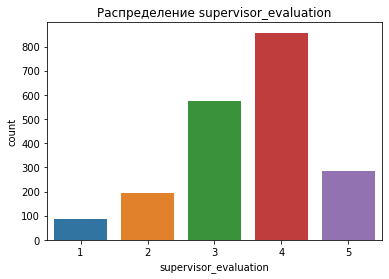

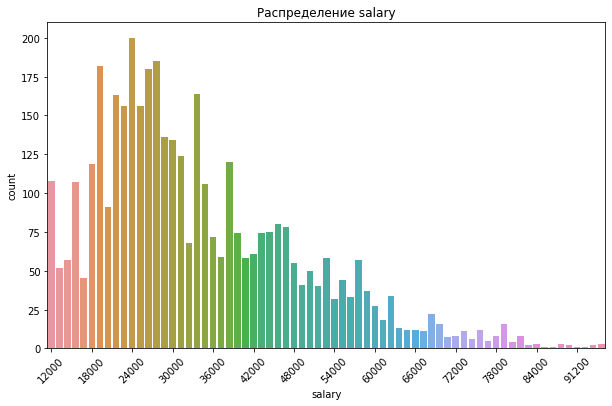

In [40]:
eda_cols = ['employment_years', 'supervisor_evaluation', 'salary']
    
for col in eda_cols:
    if col == 'salary' or col == 'job_satisfaction_rate':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, data=train_quit)
        plt.xticks(rotation=45)
        xticks = plt.xticks()[0]
        selected_xticks = xticks[::5]
        plt.xticks(selected_xticks)
        plt.title(f'Распределение {col}')
        plt.show()
    else:
        sns.countplot(x=col, data=test_features)
        plt.title(f'Распределение {col}')
        plt.show()

Распределение несимметричное, что может повлиять на обучение линейны моделей

employment_years и supervisor_evaluation - дискретные признаки, хоть и представлены в численном виде. Для этих признаков не нужно строить ящики с усами, так как признак имеет, скорее, распределение категориального признака, пусть и представленного уже в численном виде.

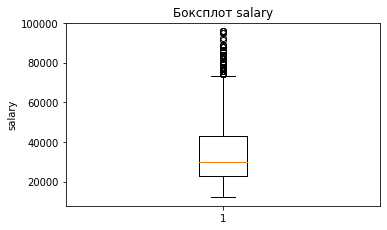

In [41]:
# Отфильтруем только числовые столбцы
numeric_columns = train_quit.select_dtypes(include=['number']).columns

plt.figure(figsize=(10, 6))
for i, column in enumerate(numeric_columns):
    if column != 'employment_years' and column != 'supervisor_evaluation':
        plt.subplot(2, 2, i + 1)
        plt.boxplot(train_quit[column])
        plt.title(f'Боксплот {column}')
        plt.ylabel(column)
plt.tight_layout()
plt.show()

**supervisor_evaluation**: есть выбросы, но значения находятся в пределах нижней оценки, котроую мы сами и установили.

**salary**: есть выбросы, но они объясняются высокими зарплатами ценных специалистов и руководителей.

In [42]:
# Группировка по отделам и подсчет количества уволившихся сотрудников
quit_by_dept = train_quit.groupby('dept')['quit'].value_counts(normalize=True).unstack()

# Вывод результатов
print("Процент уволившихся сотрудников по отделам:")
print(quit_by_dept)

# Группировка по уровню загруженности и подсчет количества уволившихся сотрудников
quit_by_workload = train_quit.groupby('workload')['quit'].value_counts(normalize=True).unstack()

# Вывод результатов
print("\nПроцент уволившихся сотрудников по уровню загруженности:")
print(quit_by_workload)

# Группировка по уровню и подсчет количества уволившихся сотрудников
quit_by_level = train_quit.groupby('level')['quit'].value_counts(normalize=True).unstack()

# Вывод результатов
print("\nПроцент уволившихся сотрудников по уровню:")
print(quit_by_level)

# Группировка по наличию повышения в прошлом году и подсчет количества уволившихся сотрудников
quit_by_promo = train_quit.groupby('last_year_promo')['quit'].value_counts(normalize=True).unstack()

# Вывод результатов
print("\nПроцент уволившихся сотрудников по наличию повышения в прошлом году:")
print(quit_by_promo)

# Группировка по наличию нарушений в прошлом году и подсчет количества уволившихся сотрудников
quit_by_violations = train_quit.groupby('last_year_violations')['quit'].value_counts(normalize=True).unstack()

# Вывод результатов
print("\nПроцент уволившихся сотрудников по наличию нарушений в прошлом году:")
print(quit_by_violations)

# Средняя зарплата всех сотрудников
avg_salary = train_quit['salary'].mean()

# Средняя зарплата ушедших сотрудников
avg_salary_quit = train_quit[train_quit['quit'] == 'yes']['salary'].mean()

# Средняя зарплата оставшихся сотрудников
avg_salary_stay = train_quit[train_quit['quit'] == 'no']['salary'].mean()

# Вывод результатов
print("\nСредняя зарплата сотрудников:", avg_salary)
print("Средняя зарплата уволившихся сотрудников:", avg_salary_quit)
print("Средняя зарплата оставшихся сотрудников:", avg_salary_stay)

Процент уволившихся сотрудников по отделам:
quit              no       yes
dept                          
hr          0.750000  0.250000
marketing   0.719931  0.280069
purchasing  0.717687  0.282313
sales       0.716968  0.283032
technology  0.702586  0.297414

Процент уволившихся сотрудников по уровню загруженности:
quit            no       yes
workload                    
high      0.820475  0.179525
low       0.570364  0.429636
medium    0.769594  0.230406

Процент уволившихся сотрудников по уровню:
quit          no       yes
level                     
junior  0.485377  0.514623
middle  0.936246  0.063754
sinior  0.952381  0.047619

Процент уволившихся сотрудников по наличию повышения в прошлом году:
quit                   no       yes
last_year_promo                    
no               0.710059  0.289941
yes              0.991150  0.008850

Процент уволившихся сотрудников по наличию нарушений в прошлом году:
quit                        no       yes
last_year_violations            

In [43]:
# Доля уволившихся по каждому фактору относительно всей численности уволившихся
print("\nДоля уволившихся по каждому фактору относительно всей численности сотрудников:")
print("-" * 50)
     
# Отдел
quit_by_dept_count = train_quit.groupby('dept')['quit'].value_counts().unstack()
for dept in quit_by_dept_count.index:
    quit_count = quit_by_dept_count.loc[dept, 'yes']
    quit_ratio = quit_count / train_quit['quit'].value_counts()['yes']
    print(f"Отдел: {dept}, Доля уволившихся (от всех уволившихся): {quit_ratio:.2f}")
    
print("-" * 30)

# Уровень загруженности
quit_by_workload_count = train_quit.groupby('workload')['quit'].value_counts().unstack()
for workload in quit_by_workload_count.index:
    quit_count = quit_by_workload_count.loc[workload, 'yes']
    quit_ratio = quit_count / train_quit['quit'].value_counts()['yes']  
    print(f"Уровень загруженности: {workload}, Доля уволившихся (от всех уволившихся): {quit_ratio:.2f}")
    
print("-" * 30)

# Профессиональный уровень
quit_by_level_count = train_quit.groupby('level')['quit'].value_counts().unstack()
for level in quit_by_level_count.index:
    quit_count = quit_by_level_count.loc[level, 'yes']
    quit_ratio = quit_count / train_quit['quit'].value_counts()['yes']  
    print(f"Профессиональный уровень: {level}, Доля уволившихся (от всех уволившихся): {quit_ratio:.2f}")
    
print("-" * 30)

# Повышение в прошлом году
quit_by_promo_count = train_quit.groupby('last_year_promo')['quit'].value_counts().unstack()
for promo in quit_by_promo_count.index:
    quit_count = quit_by_promo_count.loc[promo, 'yes']
    quit_ratio = quit_count / train_quit['quit'].value_counts()['yes']  
    print(f"Повышение в прошлом году: {promo}, Доля уволившихся (от всех уволившихся): {quit_ratio:.2f}")
    
print("-" * 30)

# Нарушения в прошлом году
quit_by_violations_count = train_quit.groupby('last_year_violations')['quit'].value_counts().unstack()
for violations in quit_by_violations_count.index:
    quit_count = quit_by_violations_count.loc[violations, 'yes']
    quit_ratio = quit_count / train_quit['quit'].value_counts()['yes']  
    print(f"Нарушения в прошлом году: {violations}, Доля уволившихся (от всех уволившихся): {quit_ratio:.2f}")
    
print("-" * 30)

# Стаж
quit_by_employment_years_count = train_quit.groupby('employment_years')['quit'].value_counts().unstack()
for employment_years in quit_by_employment_years_count.index:
    quit_count = quit_by_employment_years_count.loc[employment_years, 'yes']
    quit_ratio = quit_count / train_quit['quit'].value_counts()['yes']  
    print(f"Стаж: {employment_years}, Доля уволившихся (от всех уволившихся): {quit_ratio:.2f}")

print("-" * 50)
print("-" * 50)
print("-" * 50)    
    
# Доля уволившихся сотрудников в относительно каждой категории
print("\nДоля уволившихся сотрудников в относительно каждой категории:")
print("-" * 50)

# Отдел
dept_counts = train_quit.groupby('dept').size()
for dept in quit_by_dept.index:
    quit_count = quit_by_dept_count.loc[dept, 'yes']
    total_count = dept_counts[dept]
    quit_ratio = quit_count / total_count
    print(f"Отдел: {dept}, Доля уволившихся: {quit_ratio:.2f}")
    
print("-" * 30)
   
# Уровень загруженности
workload_counts = train_quit.groupby('workload').size()
for workload in quit_by_workload.index:
    quit_count = quit_by_workload_count.loc[workload, 'yes']
    total_count = workload_counts[workload]
    quit_ratio = quit_count / total_count
    print(f"Уровень загруженности: {workload}, Доля уволившихся: {quit_ratio:.2f}")
    
print("-" * 30)

# Профессиональный уровень
level_counts = train_quit.groupby('level').size()
for level in quit_by_level.index:
    quit_count = quit_by_level_count.loc[level, 'yes']
    total_count = level_counts[level]
    quit_ratio = quit_count / total_count
    print(f"Уровень: {level}, Доля уволившихся: {quit_ratio:.2f}")
    
print("-" * 30)
    
# Повышение в прошлом году
promo_counts = train_quit.groupby('last_year_promo').size()
for promo in quit_by_promo.index:
    quit_count = quit_by_promo_count.loc[promo, 'yes']
    total_count = promo_counts[promo]
    quit_ratio = quit_count / total_count
    print(f"Повышение в прошлом году: {promo}, Доля уволившихся: {quit_ratio:.2f}")
    
print("-" * 30)

# Нарушения в прошлом году
violations_counts = train_quit.groupby('last_year_violations').size()
for violations in quit_by_violations.index:
    quit_count = quit_by_violations_count.loc[violations, 'yes']
    total_count = violations_counts[violations]
    quit_ratio = quit_count / total_count
    print(f"Нарушения в прошлом году: {violations}, Доля уволившихся: {quit_ratio:.2f}")

print("-" * 30)
    
# Стаж
quit_by_years_count = train_quit.groupby(['employment_years', 'quit']).size().unstack(fill_value=0)
years_counts = train_quit.groupby('employment_years').size()
for years in quit_by_years_count.index:
    quit_count = quit_by_years_count.loc[years, 'yes']
    total_count = years_counts[years]
    quit_ratio = quit_count / total_count
    print(f"Стаж работы: {years}, Доля уволившихся: {quit_ratio:.2f}")


Доля уволившихся по каждому фактору относительно всей численности сотрудников:
--------------------------------------------------
Отдел: hr, Доля уволившихся (от всех уволившихся): 0.10
Отдел: marketing, Доля уволившихся (от всех уволившихся): 0.14
Отдел: purchasing, Доля уволившихся (от всех уволившихся): 0.15
Отдел: sales, Доля уволившихся (от всех уволившихся): 0.36
Отдел: technology, Доля уволившихся (от всех уволившихся): 0.24
------------------------------
Уровень загруженности: high, Доля уволившихся (от всех уволившихся): 0.11
Уровень загруженности: low, Доля уволившихся (от всех уволившихся): 0.46
Уровень загруженности: medium, Доля уволившихся (от всех уволившихся): 0.43
------------------------------
Профессиональный уровень: junior, Доля уволившихся (от всех уволившихся): 0.89
Профессиональный уровень: middle, Доля уволившихся (от всех уволившихся): 0.10
Профессиональный уровень: sinior, Доля уволившихся (от всех уволившихся): 0.02
------------------------------
Повышение 

На основании полученных результатов составим портрет уволившегося сотрудника.

**Портрет уволившегося сотрудника**

- Сотрудник, который увольняется прежде всего это молодой специалист (junior). Доля от общего числа уволившихся младших специалистов составляет - 51%, относительно всех уволившихся сотрудников - 89%.
- Чаще всего уволившиеся сотрудники имею стаж до 1 года включительно. Доля таких сотрудников 53% от всех уволившихся сотрудников.
- Отдел на решение уволиться не имеет сильного влияния. Доля уволившихся в каждом отделе примерно одинаково олт 25% до 30%.
- Все уволившиеся сотрудники не имели повышения за прошлый год и 80% из них не имели нарушений
- 43% сотрудников имеющих нихкую загрузки уволились, что составило 46% всех уволившихся. 43% от общего количества уволившихся имели среднюю загрузку, что составляет 23% от всех сотрудников имеющих среднюю загрузку.
- Средняя зарплата уволившихся ниже чем средняя зарплата по всем сотрудников.

In [44]:
display(test_target_job_satisfaction_rate.head(3))

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60


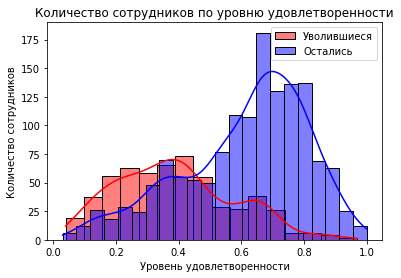

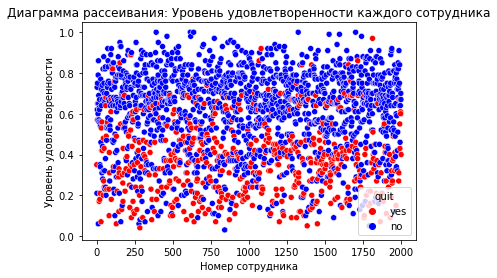

In [45]:
# Объединяем данные по id
data = test_target_quit.merge(test_target_job_satisfaction_rate, left_on='id', right_index=True)

# Визуализация количества сотрудников по уровню удовлетворенности для ушедших и оставшихся
sns.histplot(data[data['quit'] == 'yes']['job_satisfaction_rate'], label='Уволившиеся', kde=True, color='red')
sns.histplot(data[data['quit'] == 'no']['job_satisfaction_rate'], label='Остались', kde=True, color='blue')
plt.title('Количество сотрудников по уровню удовлетворенности')
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Количество сотрудников')
plt.legend()
plt.show()

# Добавляем столбец с порядковым номером сотрудника
data['employee_number'] = range(1, len(data) + 1)

# Диаграмма рассеивания
sns.scatterplot(x='employee_number', y='job_satisfaction_rate', data=data, hue='quit', palette=['red', 'blue'])
plt.title('Диаграмма рассеивания: Уровень удовлетворенности каждого сотрудника')
plt.xlabel('Номер сотрудника')
plt.ylabel('Уровень удовлетворенности')
plt.show()

**Вывод**

Даграммы показыают, что уровень удовлетворенности заметно влияет на вероятность увольнения сотрудника. Сотрудники с низким уровнем удовлетворенности увольняются гораздо чаще.

### Добавление нового входного признака

Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи

**Сначала добавим job_satisfaction_rate в тренировочную выборку**

In [46]:
# Получение лучшей модели из RandomizedSearchCV
best_model = randomized_search.best_estimator_

# Делаем предсказания на тренировочной выборке
y_quit_pred = best_model.predict(train_quit)

# Преобразуем y_quit_pred в series, чтобы объединить с train_quit
y_quit_pred = pd.Series(y_quit_pred, index=train_quit.index)

# Устанавливаем имя для y_quit_pred
y_quit_pred.name = 'job_satisfaction_rate' 

# Объединяем y_quit_pred и train_quit
train_quit = train_quit.join(y_quit_pred, how='left')

In [47]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 472.8+ KB


In [48]:
train_quit.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.553605
814010,sales,junior,medium,2,no,no,4,27600,no,0.844404
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.288491
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.279739
910140,marketing,junior,medium,2,no,no,5,25200,no,0.739828


**Теперь добавим job_satisfaction_rate в тестовую выборку**

In [49]:
# Делаем предсказания на тренировочной выборке
y_quit_pred = best_model.predict(test_features)

# Преобразуем y_quit_pred в series, чтобы объединить с train_quit
y_quit_pred = pd.Series(y_quit_pred, index=test_features.index)

# Устанавливаем имя для y_quit_pred
y_quit_pred.name = 'job_satisfaction_rate' 

# Объединяем y_quit_pred и train_quit
test_features = test_features.join(y_quit_pred, how='left')

In [50]:
test_features.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.803878
686555,hr,junior,medium,1,no,no,4,30000,0.695340
467458,sales,middle,low,5,no,no,4,19200,0.599906
418655,sales,middle,low,6,no,no,4,19200,0.654058
789145,hr,middle,medium,5,no,no,5,40800,0.719913


### Корреляционный анализ

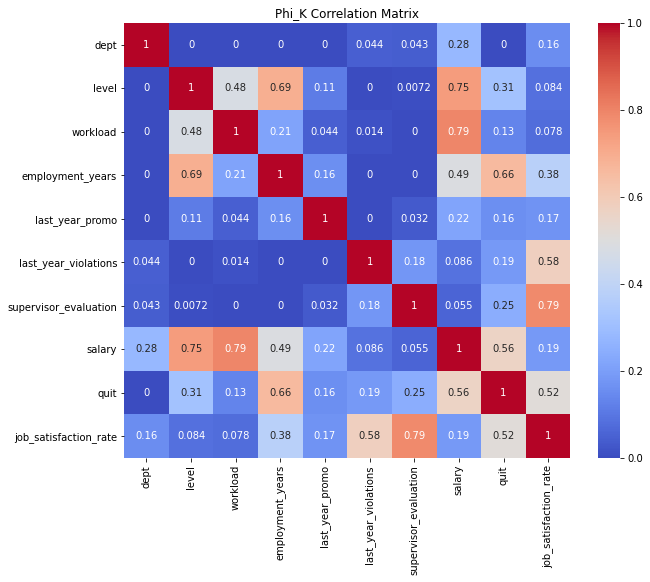

In [51]:
# Список  количественных  столбцов
interval_cols = ['salary', 'job_satisfaction_rate']

# Вычисляем  матрицы  корреляции. Передаем только список с количественными признаки. 
# Дадьше phik определит остальные признаки как категориальные
corr_matrix = train_quit.phik_matrix(interval_cols=interval_cols)

# Визуализация  матрицы  корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

In [52]:
display(corr_matrix['quit'].sort_values(ascending=False))

quit                     1.000000
employment_years         0.659093
salary                   0.564154
job_satisfaction_rate    0.515008
level                    0.312799
supervisor_evaluation    0.245489
last_year_violations     0.185071
last_year_promo          0.157370
workload                 0.132243
dept                     0.000000
Name: quit, dtype: float64

**Вывод**

Признаки с высокой положительной корреляцией к параметру 'quit': 
- employment_years(0.65), работники чаще всего склонны увольнятсяна первом и втором году работы
- salary(0.56), работники с меньшей запрлатой чаще увольняются
- job_satisfaction_rate(0.51) работники с меньшим коэффициентом удовлетворенности увольняются чаще

Признак dept имеет нулевую корреляцию и поэтому будет исключен из входных признаков для обучения модели

### Обучение модели

#### Подготовка данных

In [53]:
# Сделаем id индексом, чтобы исключить влияние id на исследование и модель обучения 
test_target_quit = test_target_quit.set_index('id')
train_quit = train_quit.sort_index()
test_target_quit = test_target_quit.sort_index()
test_data = test_features.join(test_target_quit, how='left')

In [54]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1997 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               1999 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
 9   quit                   2000 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 236.4+ KB


In [55]:
test_target_quit.head(5)

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


In [56]:
X_train = train_quit.drop('quit', axis=1)
y_train = train_quit['quit']
X_test = test_data.drop('quit', axis=1)
y_test = test_data['quit']

In [57]:
# X_train.info()

In [58]:
# print(type(X_test))
# print(type(y_test))
# print(type(X_train))
# print(type(y_train))

In [59]:
# Создаем LabelEncoder
le = LabelEncoder()

# Обучаем LabelEncoder на y_train,  устанавливая соответствие "no" -> 0, "yes" -> 1
le.fit(['no', 'yes'])  

# Преобразуем y_train и y_test 
y_train = le.transform(y_train)
y_test = le.transform(y_test)


In [60]:
print(le.classes_)

['no' 'yes']


Создадим списки с названиями признаков, чтобы на основании этих списков прокодировать признаки в пайплайне

In [61]:
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [62]:
RANDOM_STATE = 42

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore')) 
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns) # StandardScaler() больше подходит для линейныхх моделей, чем MinMaxScaler()
    ], 
    remainder='passthrough'
)

#### Обучение модели

In [63]:
%%time
# Создаем пайплайн для модели и подбора гиперпараметров
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Определяем параметры для RandomizedSearchCV
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
     # словарь для модели SVC()
     # probability=True в SVC позволяет модели вычислять вероятности классов для каждого образца
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['linear', 'rbf'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=10,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise',
    n_iter=10   
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImput

#### Вывод

**Лучшая модель**
1. Лучшей моделью оказалась метрика KNeighborsClassifier с параметрами n_neighbors=20.
2. Метрика ROC-AUC на обучающей выборке равна 0,929, а на тестовой — 0,920. Это говорит о том, что модель хорошо работает на новых данных и не переобучена.

**Почему KNeighborsClassifier оказалось лучшей моделью?**
1. В данном случае алгоритм модели более простой чем остальные но оказался более гибким, чтобы уловить зависимости в данных.
2. Также данный алгоритм более устойчив к выбросам и к несимметричному распределению данных.
3. Возможно данные имеют нелинейные зависимости, которые лучше улавливает KNeighborsClassifie, чем линейные алгоритмы в остальных моделях.

## Общий вывод

### Описание задачи
Удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Необходимо построить две прогнозные модели. Первая - предсказывает уровень удовлетворённости сотрудника, вторая - предсказывает
уволится ли сотрудник.

### Построение первой модели "Предсказание удовлетворенности сотрудника"
**Предобработка данных**
- Была проведена замена ячеек заполненных ' ' на nan в столбцах dept и workload в выборке test_features

**Исследовательский анализ**
- Аномальные значения ввыборках отсутствуют. 
- Ближе всего к нормальному распределение job_satisfaction_rate, которое не должно существенно влиять на работу моделей. У остальных признаков распределение ассимитричное, что часто встречается в жизни и что может повлиять на работу линейных моделей и привести к неточным прогнозам. Сгладить ассиметрию нам помогут StandardScaler и MinMaxScaler, которые мы используем в пайплайне.
- supervisor_evaluation: есть выбросы, но значения находятся в пределах нижней оценки, котроую мы сами и установили.
- salary: есть выбросы, но они объясняются высокими зарплатами ценных специалистов и руководителей. Самые высокие зарплаты у технических специалистов и выбросы в данном случае отображают положение данной подгруппы (тех. специалисты) по показателяю. А значит они нужны нам для построения и прогносзирования модели по данной подгруппе.
- last_year_promo: низкий процент повышения (3%), это может говорить опроблемах х с системой карьерного роста.
- last_year_violations: 14%, нарушения могут влияють на уровень удовлетворенности сотрудников

**Корреляционный анализ**
- supervisor_evaluation (0.76): сильная положительная корреляция, оценка руководителя оказывает значительное влияние на уровень удовлетворённости сотрудников
- supervisor_evaluation (0.56): сильная корреляция, тут скорее обратная логика, чем менее удовлетворен сотрудник тем больше он нарушает, но тем не менее является показателем, того что сотрудник неудовлетворен чем то.
- last_year_violations (0.32): умеренная корреляция, может указывать на то, что более опытные сотрудники, как правило, более удовлетворены своей работой
- last_year_0.17): слабая положительная корреляция, может указывать на то, что зарплата оказывает очень слабое влияния на удовлетворённость
- level, dept, workload практически не коррелируют

**Создание пайплайна обучения моделей на тренировочной выборке с проверкой работы лучшей модели на тестовых данных**
- Данные тренировочной выборки были разделены на числовые, категориальные и порядковые категориальные. На основе данного разделения был создан пайплайн предподготовки данных для обученяи модели
- На сонове метода для гиперпараметрической оптимизации в машинном обучении RandomizedSearchCV() и линейных алгоритмов машиноого обучения DecisionTreeRegressor(), LinearRegression(), KNeighborsClassifier() ,SVR() мы провели подборку лучшей прогнозной  модели для предсказания уровеня удовлетворённости сотрудника.
- При оценке качества модели была применена метрика SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение») — метрика оценки точности прогнозов в задачах регрессии. Она представляет собой улучшенную версию MAPE (среднего абсолютного процентного отклонения), поскольку более симметрично учитывает разницу между фактическими и прогнозируемыми значениями, минимизируя влияние экстремальных значений. Формула SMAPE определяется как: SMAPE = (1/N) × (2 × |y_i – f(x_i)|) / (|y_i| + |f(x_i)|) × 100%. Эта метрика особенно полезна, когда данные включают нулевые или очень маленькие значения, а также когда различия в масштабах между истинными и прогнозируемыми значениями могут существенно исказить результаты оценки. 
- Лучшая модель: SVR(C=10) с StandardScaler как предобработкой показала самый низкий SMAPE (-14.48) на тренировочной выборке. SMAPE на тестовой выборке немного выше (13.51), что указывает на возможное переобучение модели.
- Другие модели: DecisionTreeRegressor с StandardScaler и гиперпараметрами max_depth=3, max_features=4 (строка 4) также показывает хорошие результаты (-14.48 на тренировочной выборке). KNeighborsRegressor и SVR с другими гиперпараметрами демонстрируют более низкое качество по сравнению с лучшими моделями SVR и DecisionTreeRegressor.
- Предобработка: StandardScaler показывает лучшие результаты по сравнению с MinMaxScaler и passthrough.

**Рекомендации бизнесу**
- Улучшить систему карьерного роста: низкий процент повышений может демотивировать сотрудников
- Проведение тренингов для руководителей: эффективные методы обратной связи, делегирования и мотивации могут сыграть решающую роль в мотивации.
- Развитие моделей прогнозирования удовлетворенности: внедрение системы регулярного мониторинга модели.

### Построение второй модели "Предсказание уволится ли сотрудник"
**Исследовательский анализ**

По итогам исследовательского анализа данных был сформирован портрет сотрудника,который уволится:
- Сотрудник, который увольняется прежде всего это молодой специалист (junior). Доля от общего числа уволившихся младших специалистов составляет - 51%, относительно всех уволившихся сотрудников - 89%.
- Чаще всего уволившиеся сотрудники имею стаж до 1 года включительно. Доля таких сотрудников 53% от всех уволившихся сотрудников.
- Отдел на решение уволиться не имеет сильного влияния. Доля уволившихся в каждом отделе примерно одинаково олт 25% до 30%.
- Все уволившиеся сотрудники не имели повышения за прошлый год и 80% из них не имели нарушений
- 43% сотрудников имеющих нихкую загрузки уволились, что составило 46% всех уволившихся. 43% от общего количества уволившихся имели среднюю загрузку, что составляет 23% от всех сотрудников имеющих среднюю загрузку.
- Средняя зарплата уволившихся ниже чем средняя зарплата по всем сотрудников.

**Добавление нового входного признака в тренировочные данные**
- В ходе выполнения проекта была проведена проверка влияния коэффициента удовлетворенности сотрудника на вероятность кго увольнения. На данных об увольнении сотруниках была применена нащша модель предсказания удовлетворенности сотрудника из первой задачи, при помощи которой мы предсказали коэффициент удовлетоворенности сотрудников для тренировочной и тестовой выборок. Далее мы проверди корреляционный анализ и приняли решение добавить новый входной признак 'job_satisfaction_rate'.


**Корреляционный анализ**

Признаки с высокой положительной корреляцией к параметру 'quit': 
- employment_years(0.65), работники чаще всего склонны увольнятсяна первом и втором году работы
- salary(0.56), работники с меньшей запрлатой чаще увольняются
- job_satisfaction_rate(0.51) работники с меньшим коэффициентом удовлетворенности увольняются чаще

Признак dept имеет нулевую корреляцию и поэтому был исключен из входных признаков для обучения модели

**Создание пайплайна обучения моделей на тренировочной выборке с проверкой работы лучшей модели на тестовых данных**
- Данные тренировочной выборки были разделены на числовые, категориальные и порядковые категориальные. На основе данного разделения был создан пайплайн предподготовки данных для обученяи модели
- На сонове метода для гиперпараметрической оптимизации в машинном обучении RandomizedSearchCV() и линейных алгоритмов машиноого обучения DecisionTreeClassifier(), LogisticRegression(), SVC(), KNeighborsClassifier() мы провели подборку лучшей прогнозной  модели для предсказания уровеня удовлетворённости сотрудника.
- При оценке качества модели была применена метрика это количественная характеристика качества бинарной классификации. Она измеряет площадь под ROC-кривой, которая показывает зависимость между чувствительностью (Recall) и специфичностью (1 — False Positive Rate) при различных порогах классификации.
- Лучшая модель
   1. Лучшей моделью оказалась метрика KNeighborsClassifier с параметрами n_neighbors=20.
   2. Метрика ROC-AUC на обучающей выборке равна 0,929, а на тестовой — 0,920. Это говорит о том, что модель хорошо работает на новых данных и не переобучена.

- Почему KNeighborsClassifier оказалось лучшей моделью?
   1. В данном случае алгоритм модели более простой чем остальные но оказался более гибким, чтобы уловить зависимости в данных.
   2. Также данный алгоритм более устойчив к выбросам и к несимметричному распределению данных.
   3. Возможно данные имеют нелинейные зависимости, которые лучше улавливает KNeighborsClassifie, чем линейные алгоритмы в остальных моделях.
   
**Рекомендации бизнесу**
- Программа адаптации молодых сотрудников: разработка и внедрение программы адаптации для молодых специалистов (junior) должна включать интенсивное обучение, наставничество, создание комфортной атмосферы и проведение опросов об уровне удовлетворенности в первые месяцы работы.
- Пересмотр уровня заработной платы для младших сотрудников, возможно, с учетом конкурентного рынка труда.
- Удержание сотрудников с невысоким уровнем удовлетворенности: опрос сотрудников и обратная связь, разработка программ развития
- Пересмотр уровня загрузки: пересмотр загрузки сотрудников, особенном олодых специалистов с низким уровнем загрузки
- Развитие моделей прогнозирования удовлетворенности: внедрение системы регулярного мониторинга модели.